In [ ]:
### POSTPLOTS.IPYNB -- plots of recovered twin-star parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scipy
from scipy.interpolate import interp1d

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

sns.set_palette('Set1',color_codes=True)

EOSDIR = './etc/'
DATDIR = './dat/'
PLTDIR = './plt/'

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

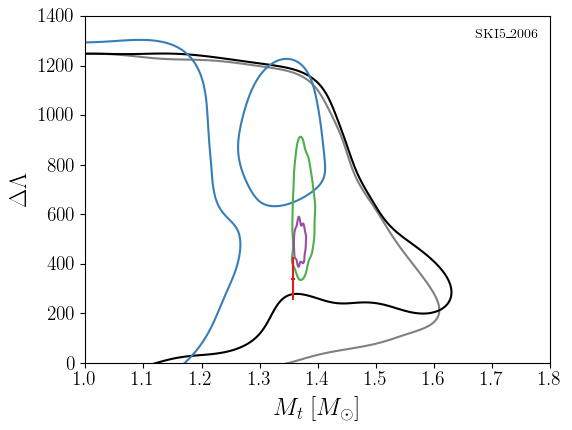

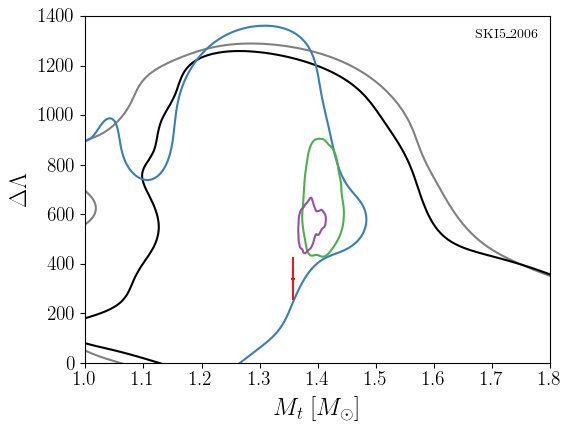

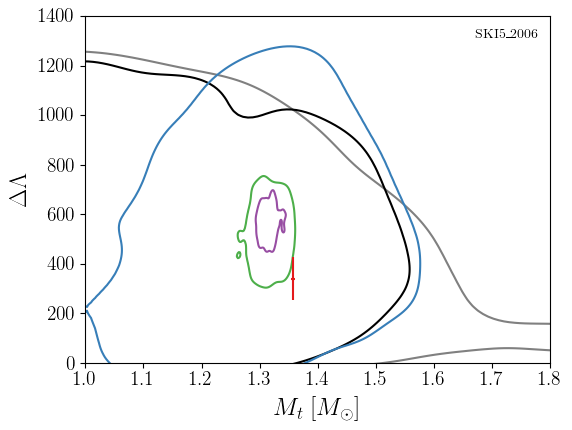

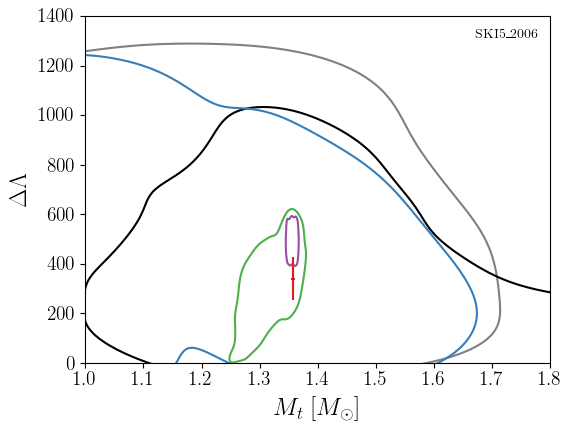

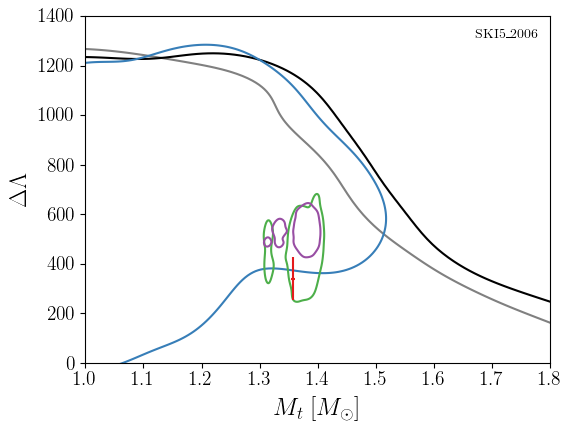

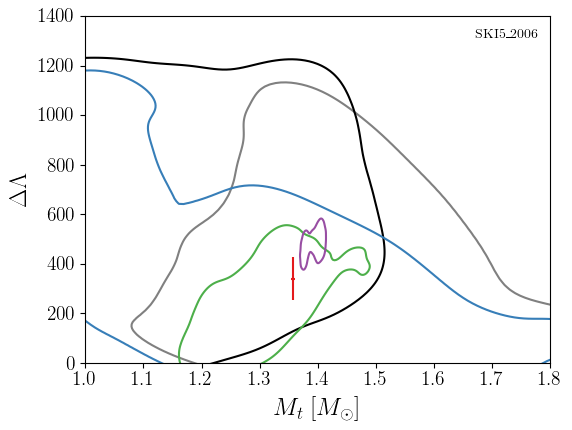

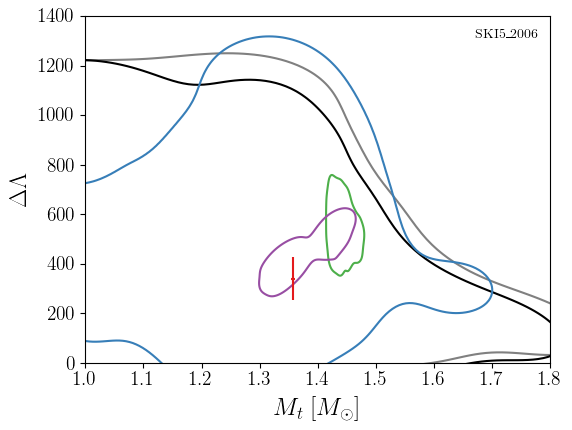

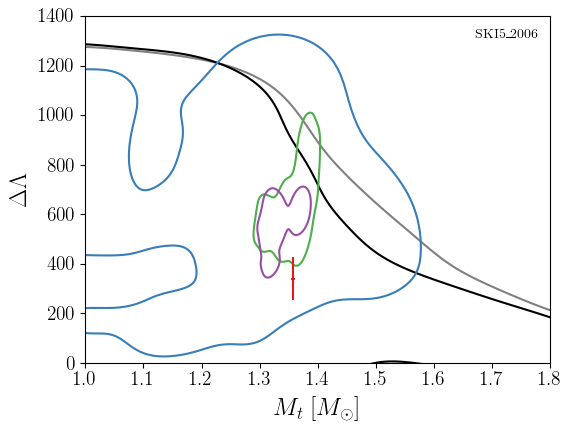

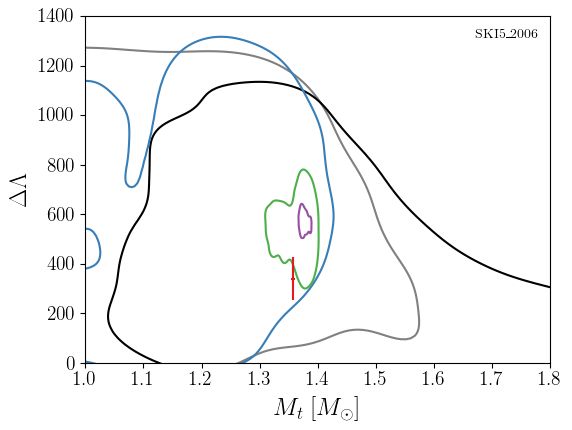

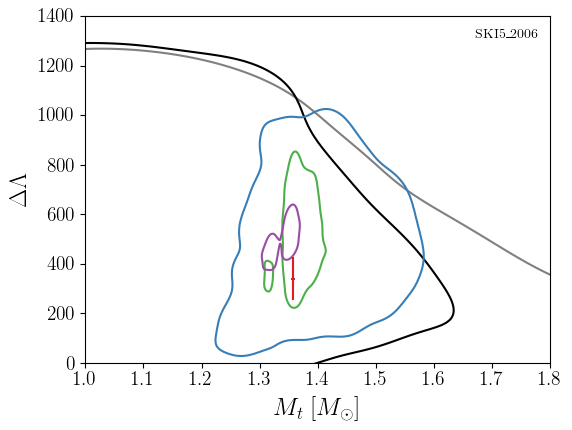

In [3]:
eos = 'SKI52006'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v1','v2','v3','v4', 'v5','v6','v7','v8','v9']

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario])
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    #plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SKI5_2006')
    
    eos_path = EOSDIR+'macro-SKI5_2006.csv'
    
    eos_dat = np.genfromtxt(eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
    Ms = eos_dat['M']
    Lambdas = eos_dat['Lambda']

    Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
    Ms = Ms[:Mmax_pos+1]
    Mmax = Ms[-1]
    Lambdas = Lambdas[:Mmax_pos+1]

    onset = np.where(np.gradient(Ms) < 0.)[0][0] # may need to adjust these based on EOS - validate manually
    offset = np.where(np.gradient(Ms) < 0.)[0][-1]

    Mtwin_f = Ms[onset]
    Mtwin_i = Ms[offset]

    hadron = np.where(Ms >= Mtwin_i)[0][0]-1 # may need to adjust these based on EOS - validate manually
    hybrid = np.where(Ms <= Mtwin_f)[0][-1]

    Lambda_of_M_pre = interp1d(Ms[:hadron+2],Lambdas[:hadron+2],kind='linear',bounds_error=True) # interpolate Lambda(M) function
    Lambda_of_M_post = interp1d(Ms[hybrid:],Lambdas[hybrid:],kind='linear',bounds_error=True)
    Lambda_of_M_hadron = interp1d(Ms[hadron:onset+3],Lambdas[hadron:onset+3],kind='linear',bounds_error=True)
    Lambda_of_M_hybrid = interp1d(Ms[offset:hybrid+3],Lambdas[offset:hybrid+3],kind='linear',bounds_error=True)

    def Lambda_of_M(m):

        if m < Mtwin_i: return Lambda_of_M_pre(m)

        elif m >= Mtwin_f: return Lambda_of_M_post(m)

        else: 
            branch = np.random.randint(0,2,1)[0]
            branches = [Lambda_of_M_hadron, Lambda_of_M_hybrid]
            return branches[branch](m)
    
    yerr = 0.5*(np.max(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100)))-np.min(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100))))
    xerr = 0.5*(Mtwin_f - Mtwin_i)
    
    plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=yerr,xerr=xerr,fmt='none',c=sns.color_palette()[0],zorder=10)
    plt.plot([0.,0.],[0.,0.],alpha=0.,c='k',label='SKI5_2006')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

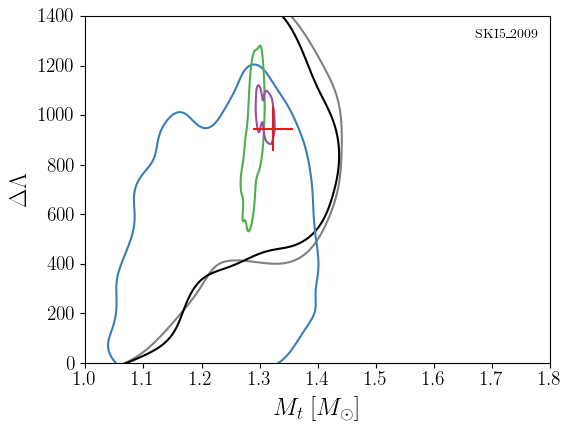

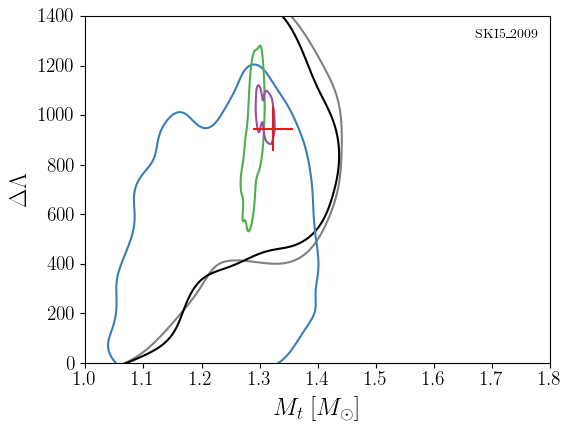

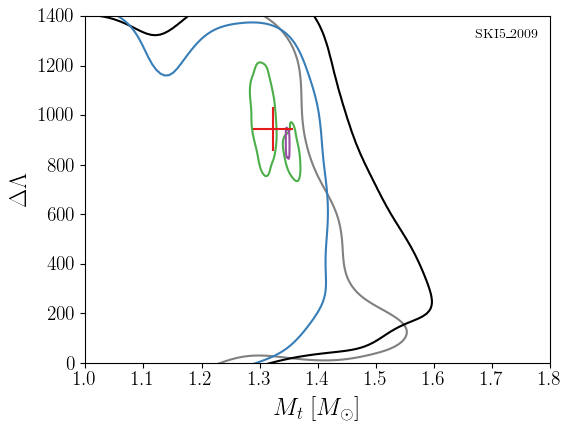

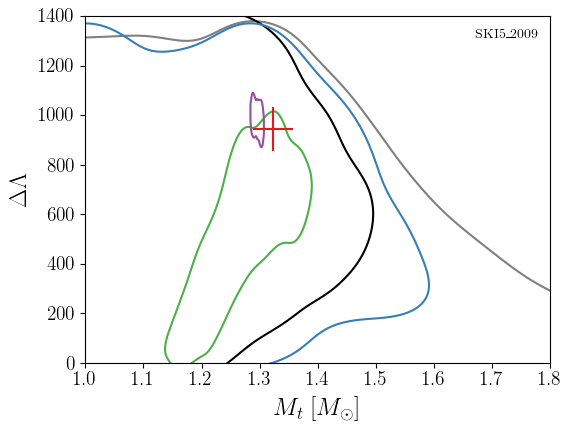

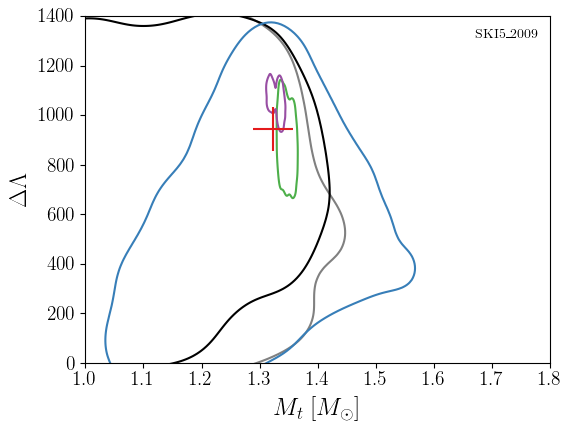

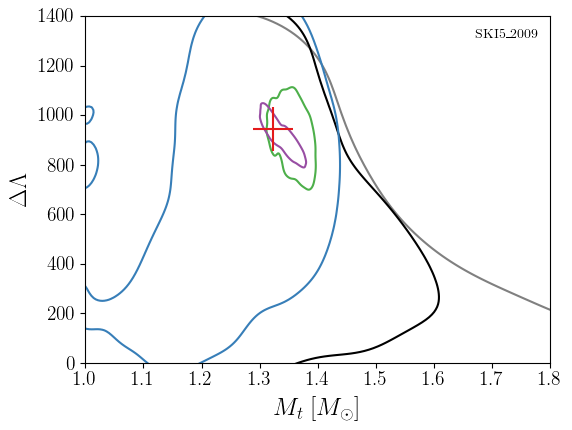

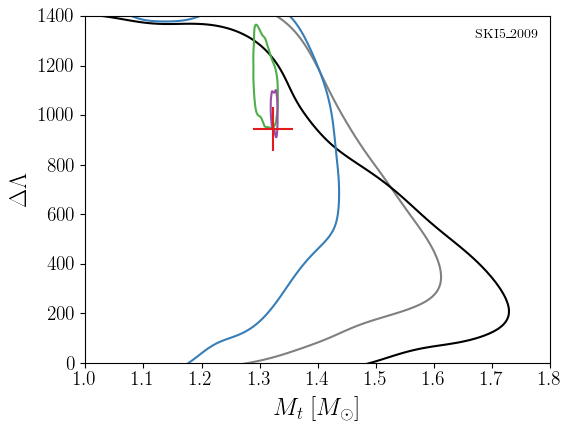

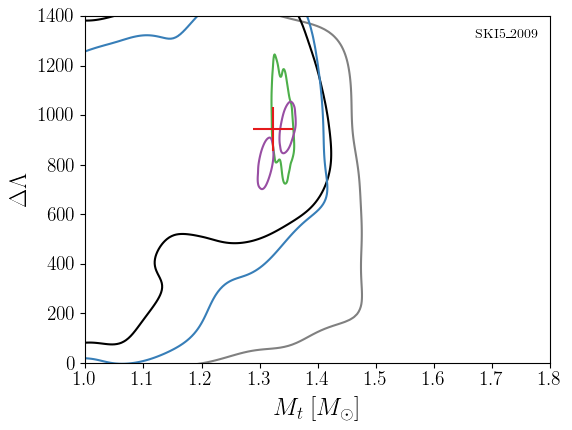

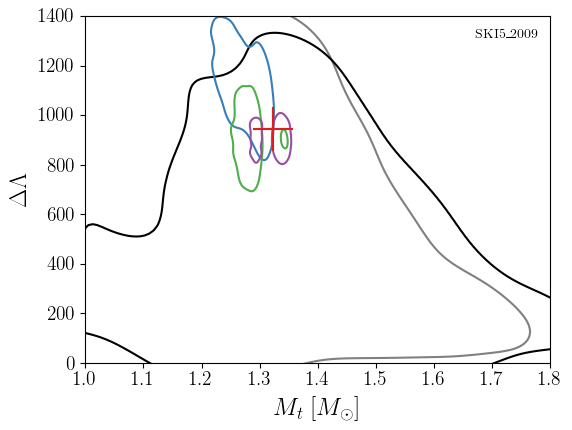

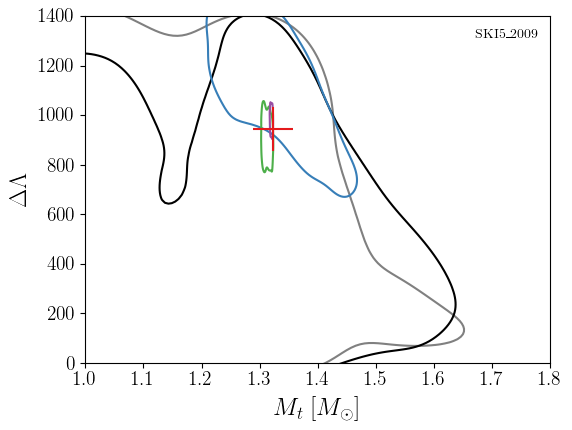

In [4]:
eos = 'SKI52009'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v0','v2','v3','v4', 'v5','v6','v7','v8','v9'] # need to rerun v1

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario])
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    #plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SKI5_2006')
    
    eos_path = EOSDIR+'macro-SKI5_2009.csv'
    
    eos_dat = np.genfromtxt(eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
    Ms = eos_dat['M']
    Lambdas = eos_dat['Lambda']

    Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
    Ms = Ms[:Mmax_pos+1]
    Mmax = Ms[-1]
    Lambdas = Lambdas[:Mmax_pos+1]

    onset = np.where(np.gradient(Ms) < 0.)[0][0] # may need to adjust these based on EOS - validate manually
    offset = np.where(np.gradient(Ms) < 0.)[0][-1]

    Mtwin_f = Ms[onset]
    Mtwin_i = Ms[offset]

    hadron = np.where(Ms >= Mtwin_i)[0][0]-1 # may need to adjust these based on EOS - validate manually
    hybrid = np.where(Ms <= Mtwin_f)[0][-1]

    Lambda_of_M_pre = interp1d(Ms[:hadron+2],Lambdas[:hadron+2],kind='linear',bounds_error=True) # interpolate Lambda(M) function
    Lambda_of_M_post = interp1d(Ms[hybrid:],Lambdas[hybrid:],kind='linear',bounds_error=True)
    Lambda_of_M_hadron = interp1d(Ms[hadron:onset+3],Lambdas[hadron:onset+3],kind='linear',bounds_error=True)
    Lambda_of_M_hybrid = interp1d(Ms[offset:hybrid+3],Lambdas[offset:hybrid+3],kind='linear',bounds_error=True)

    def Lambda_of_M(m):

        if m < Mtwin_i: return Lambda_of_M_pre(m)

        elif m >= Mtwin_f: return Lambda_of_M_post(m)

        else: 
            branch = np.random.randint(0,2,1)[0]
            branches = [Lambda_of_M_hadron, Lambda_of_M_hybrid]
            return branches[branch](m)
    
    yerr = 0.5*(np.max(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100)))-np.min(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100))))
    xerr = 0.5*(Mtwin_f - Mtwin_i)
    
    plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=yerr,xerr=xerr,fmt='none',c=sns.color_palette()[0],zorder=10)
    plt.plot([0.,0.],[0.,0.],alpha=0.,c='k',label='SKI5_2009')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

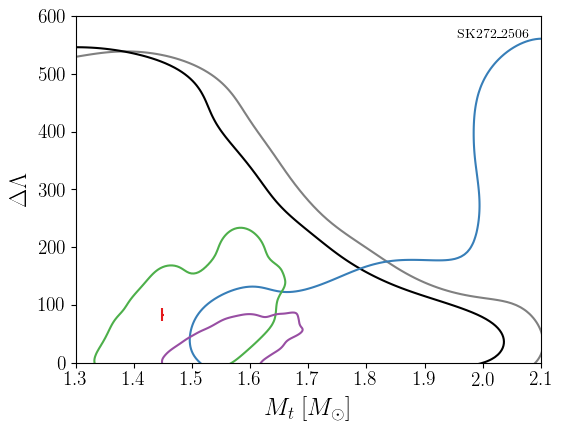

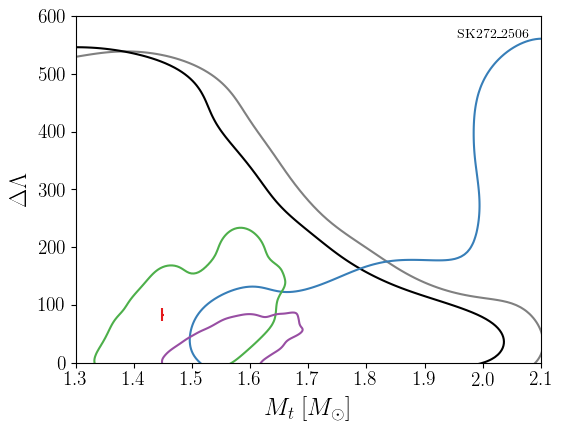

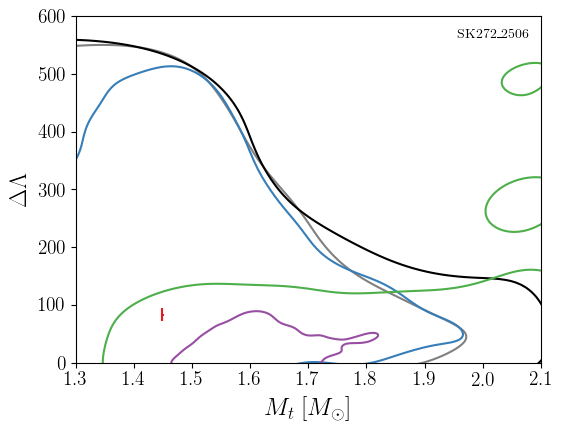

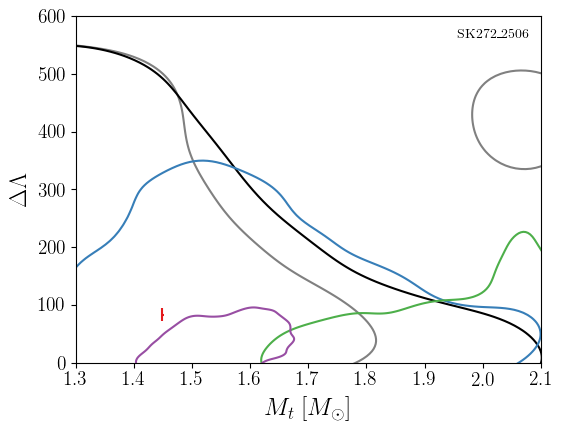

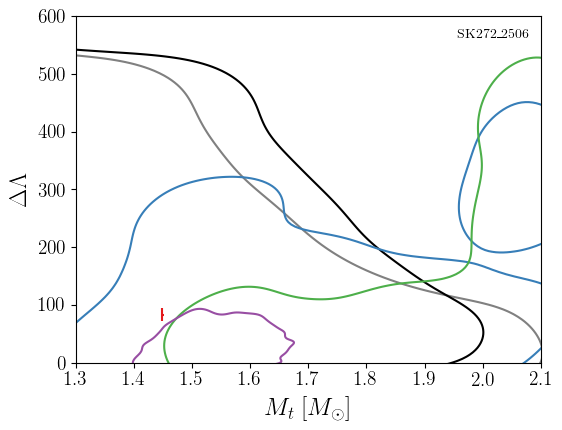

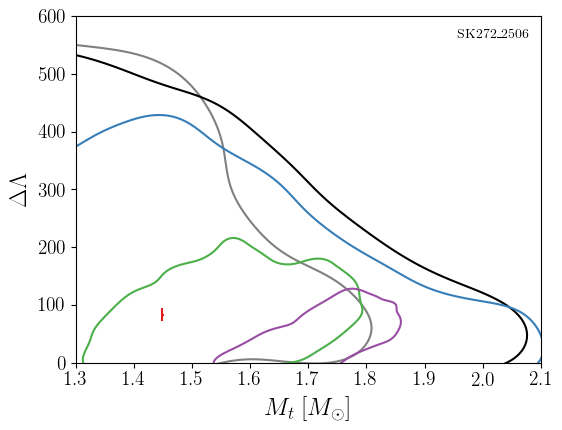

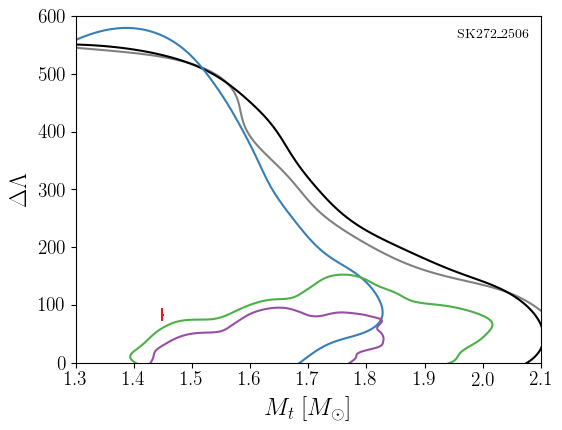

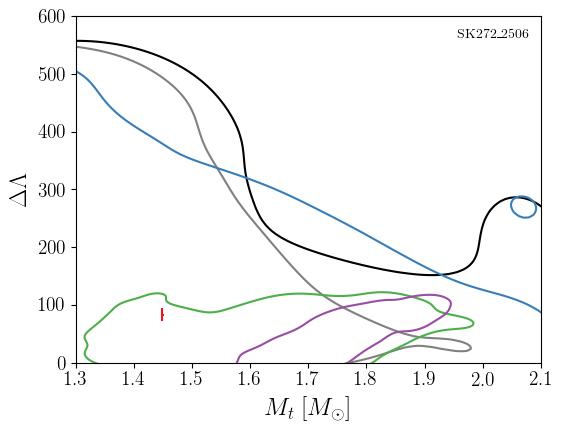

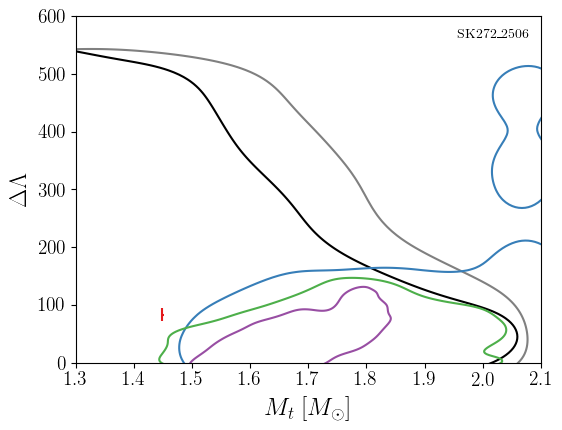

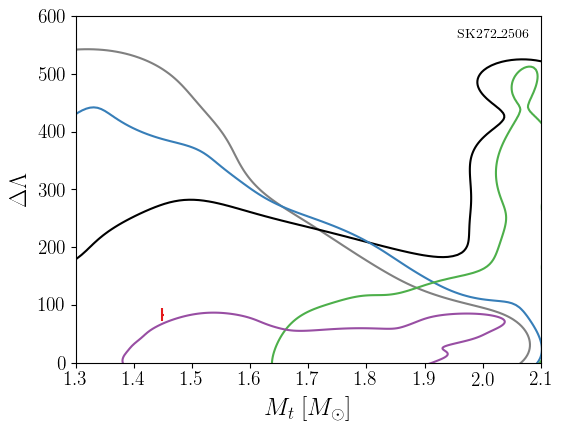

In [5]:
eos = 'SK2722506'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v0','v2','v3','v4', 'v5','v6','v7','v8','v9'] # need to rerun v1

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario])
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    #plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SKI5_2006')
    
    eos_path = EOSDIR+'macro-SK272_2506.csv'
    
    eos_dat = np.genfromtxt(eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
    Ms = eos_dat['M']
    Lambdas = eos_dat['Lambda']

    Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
    Ms = Ms[:Mmax_pos+1]
    Mmax = Ms[-1]
    Lambdas = Lambdas[:Mmax_pos+1]

    onset = np.where(np.gradient(Ms) < 0.)[0][0] # may need to adjust these based on EOS - validate manually
    offset = np.where(np.gradient(Ms) < 0.)[0][-1]

    Mtwin_f = Ms[onset]
    Mtwin_i = Ms[offset]

    hadron = np.where(Ms >= Mtwin_i)[0][0]-1 # may need to adjust these based on EOS - validate manually
    hybrid = np.where(Ms <= Mtwin_f)[0][-1]

    Lambda_of_M_pre = interp1d(Ms[:hadron+2],Lambdas[:hadron+2],kind='linear',bounds_error=True) # interpolate Lambda(M) function
    Lambda_of_M_post = interp1d(Ms[hybrid:],Lambdas[hybrid:],kind='linear',bounds_error=True)
    Lambda_of_M_hadron = interp1d(Ms[hadron:onset+3],Lambdas[hadron:onset+3],kind='linear',bounds_error=True)
    Lambda_of_M_hybrid = interp1d(Ms[offset:hybrid+3],Lambdas[offset:hybrid+3],kind='linear',bounds_error=True)

    def Lambda_of_M(m):

        if m < Mtwin_i: return Lambda_of_M_pre(m)

        elif m >= Mtwin_f: return Lambda_of_M_post(m)

        else: 
            branch = np.random.randint(0,2,1)[0]
            branches = [Lambda_of_M_hadron, Lambda_of_M_hybrid]
            return branches[branch](m)
    
    yerr = 0.5*(np.max(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100)))-np.min(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100))))
    xerr = 0.5*(Mtwin_f - Mtwin_i)
    
    plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=yerr,xerr=xerr,fmt='none',c=sns.color_palette()[0],zorder=10)
    plt.plot([0.,0.],[0.,0.],alpha=0.,c='k',label='SK272_2506')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

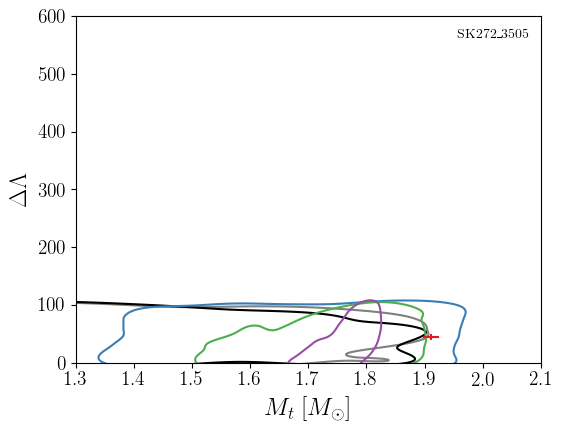

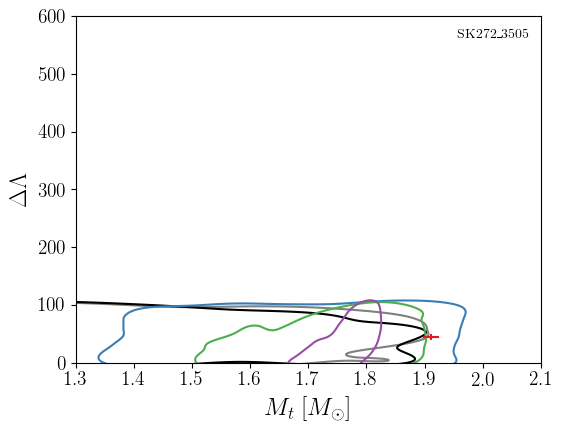

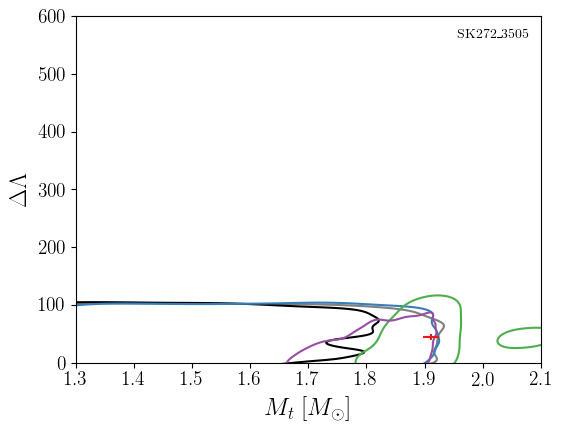

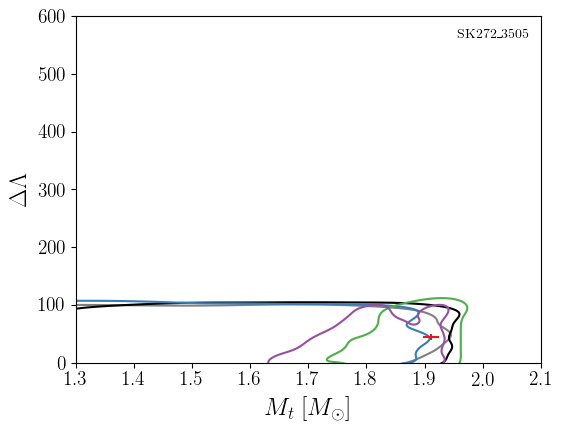

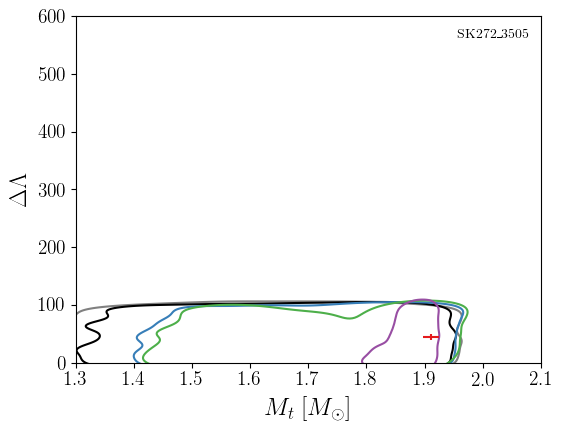

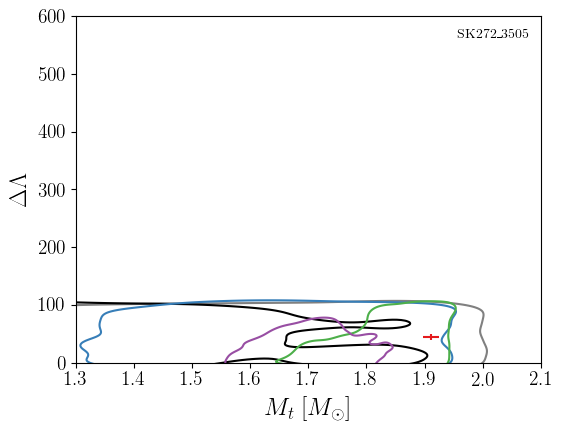

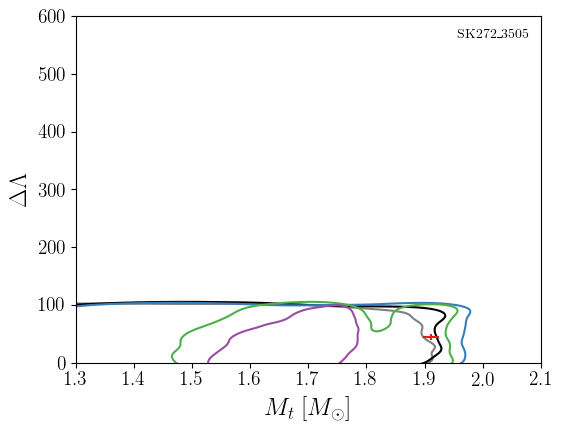

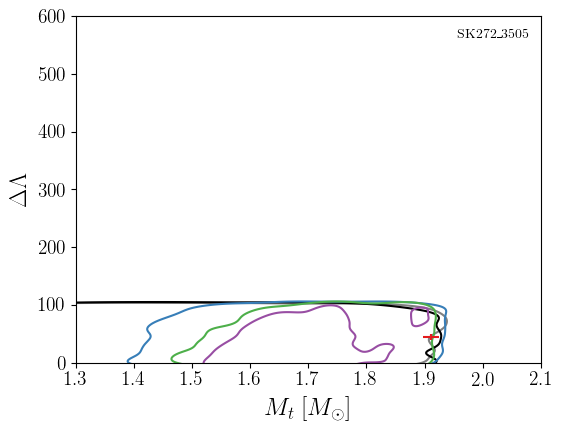

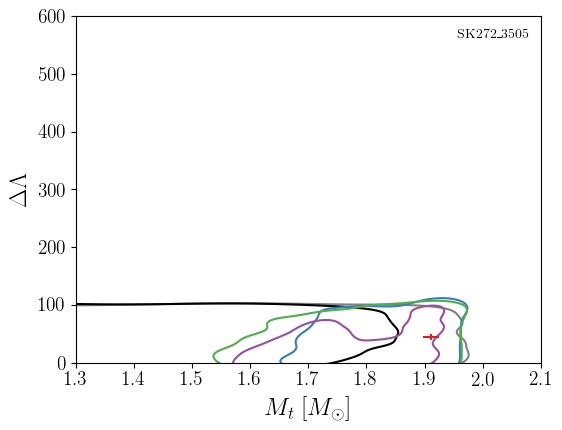

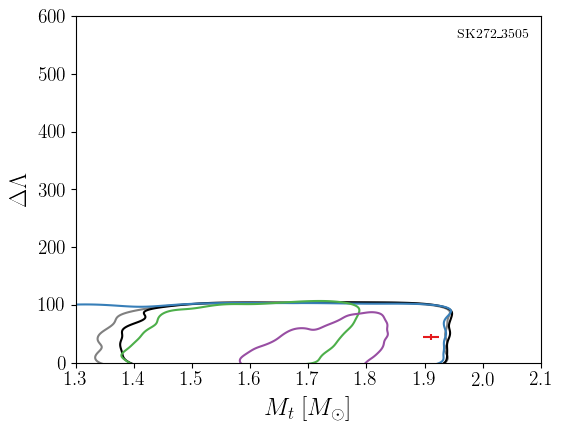

In [6]:
eos = 'SK2723505'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v0','v2','v3','v4', 'v5','v6','v7','v8','v9'] # need to rerun v1

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario])
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    #plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SKI5_2006')
    
    eos_path = EOSDIR+'macro-SK272_3505.csv'
    
    eos_dat = np.genfromtxt(eos_path,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
    Ms = eos_dat['M']
    Lambdas = eos_dat['Lambda']

    Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
    Ms = Ms[:Mmax_pos+1]
    Mmax = Ms[-1]
    Lambdas = Lambdas[:Mmax_pos+1]

    onset = np.where(np.gradient(Ms) < 0.)[0][0] # may need to adjust these based on EOS - validate manually
    offset = np.where(np.gradient(Ms) < 0.)[0][-1]

    Mtwin_f = Ms[onset]
    Mtwin_i = Ms[offset]

    hadron = np.where(Ms >= Mtwin_i)[0][0]-1 # may need to adjust these based on EOS - validate manually
    hybrid = np.where(Ms <= Mtwin_f)[0][-1]

    Lambda_of_M_pre = interp1d(Ms[:hadron+2],Lambdas[:hadron+2],kind='linear',bounds_error=True) # interpolate Lambda(M) function
    Lambda_of_M_post = interp1d(Ms[hybrid:],Lambdas[hybrid:],kind='linear',bounds_error=True)
    Lambda_of_M_hadron = interp1d(Ms[hadron:onset+3],Lambdas[hadron:onset+3],kind='linear',bounds_error=True)
    Lambda_of_M_hybrid = interp1d(Ms[offset:hybrid+3],Lambdas[offset:hybrid+3],kind='linear',bounds_error=True)

    def Lambda_of_M(m):

        if m < Mtwin_i: return Lambda_of_M_pre(m)

        elif m >= Mtwin_f: return Lambda_of_M_post(m)

        else: 
            branch = np.random.randint(0,2,1)[0]
            branches = [Lambda_of_M_hadron, Lambda_of_M_hybrid]
            return branches[branch](m)
    
    yerr = 0.5*(np.max(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100)))-np.min(Lambda_of_M_hadron(np.linspace(Mtwin_i,Mtwin_f,100))-Lambda_of_M_hybrid(np.linspace(Mtwin_i,Mtwin_f,100))))
    xerr = 0.5*(Mtwin_f - Mtwin_i)
    
    plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=yerr,xerr=xerr,fmt='none',c=sns.color_palette()[0],zorder=10)
    plt.plot([0.,0.],[0.,0.],alpha=0.,c='k',label='SK272_3505')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

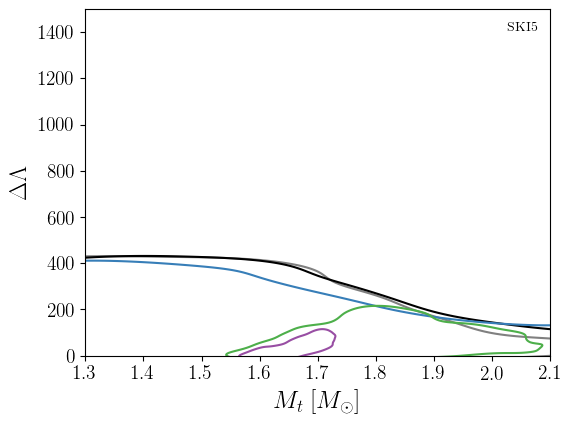

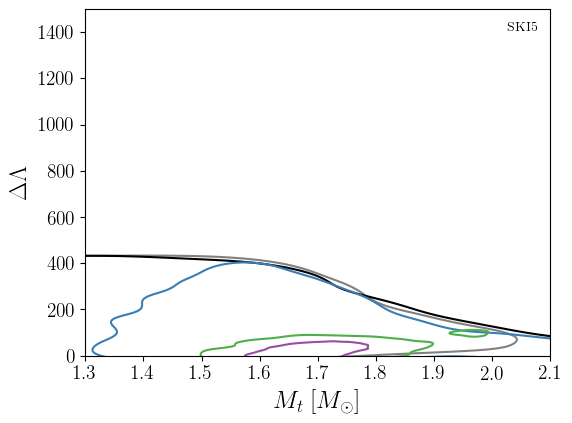

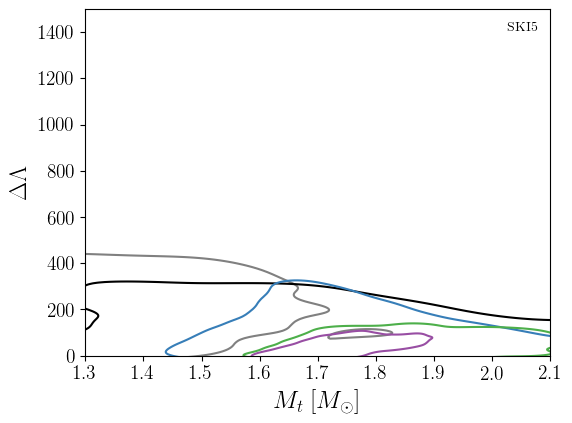

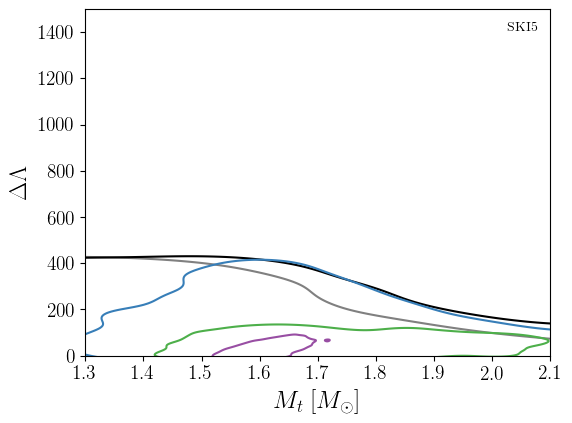

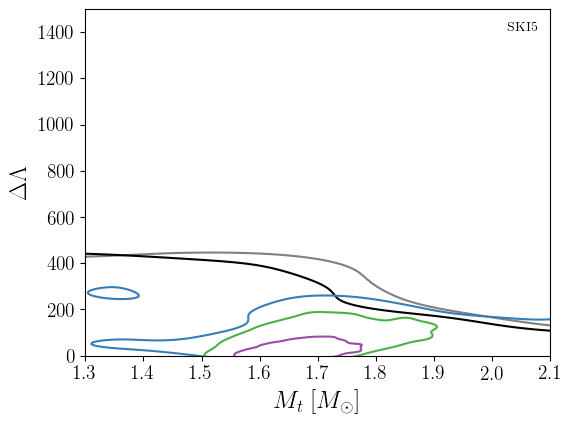

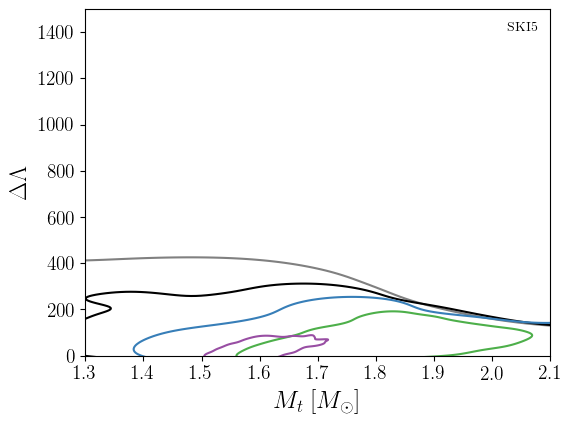

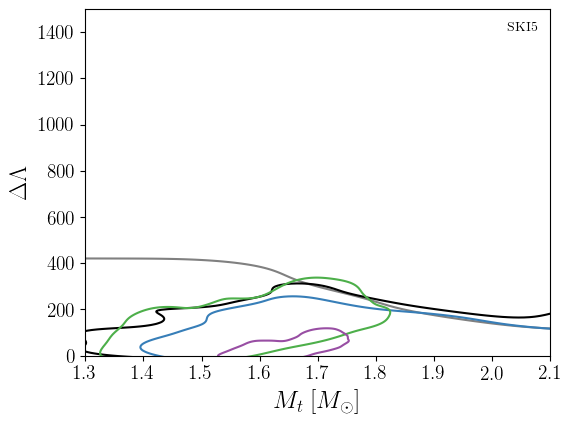

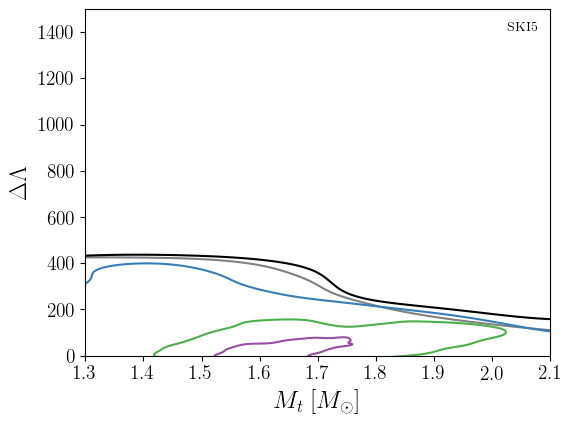

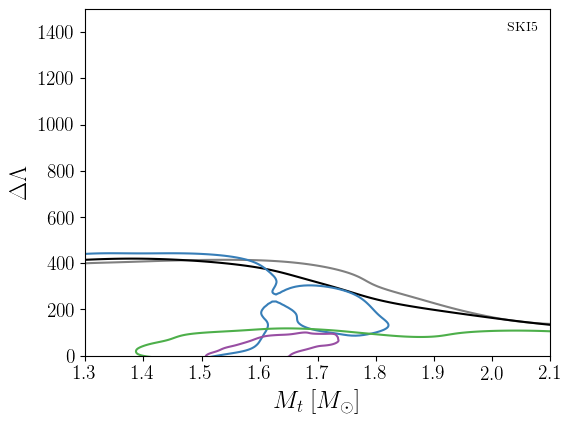

In [7]:
eos = 'SKI5'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v2','v3','v4', 'v5','v6','v7','v8','v9'] # 'v1',

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario]
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SKI5',alpha=0.)
    #plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=0.,xerr=0.068,marker='+',c=sns.color_palette()[0],zorder=10,label='injection')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passi

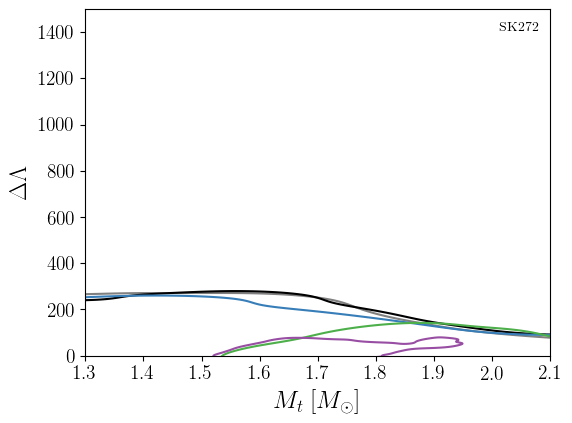

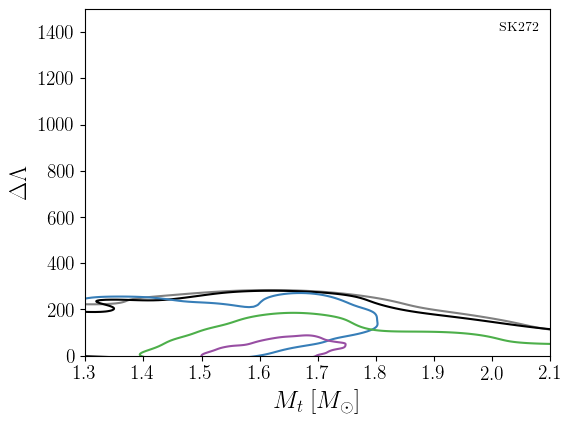

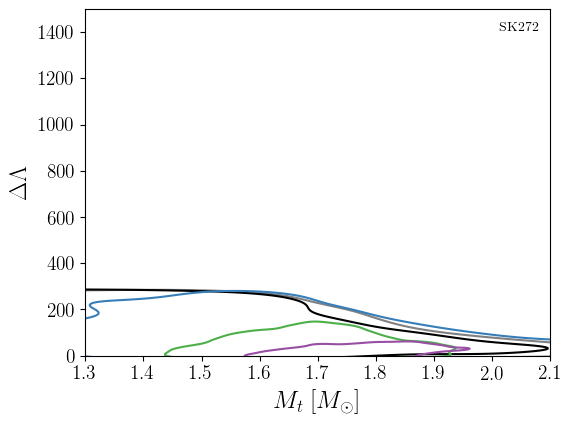

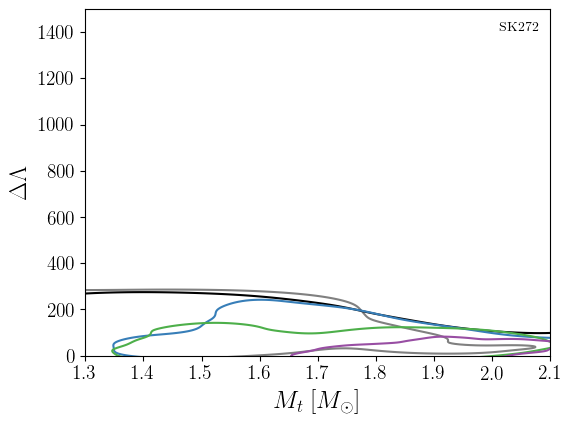

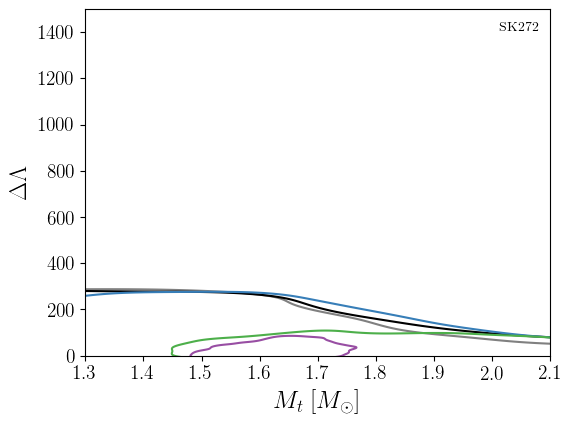

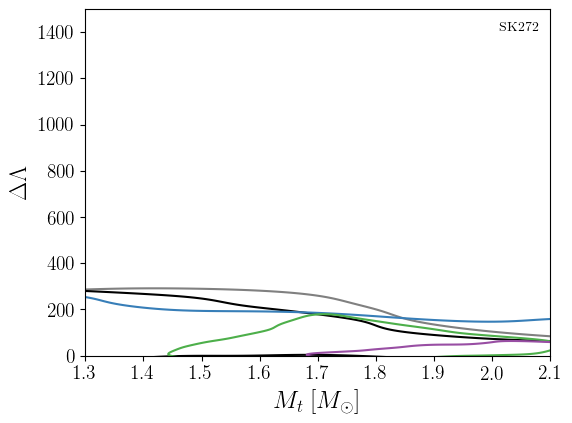

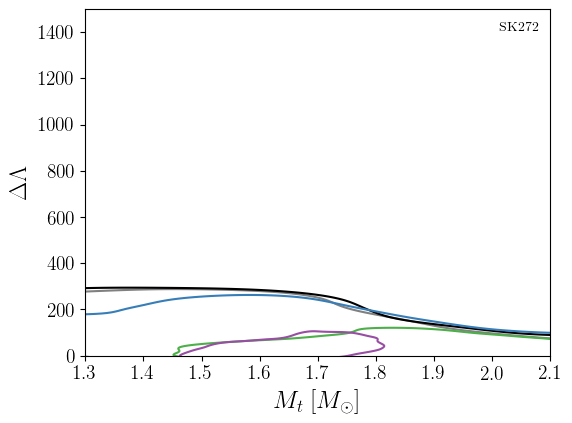

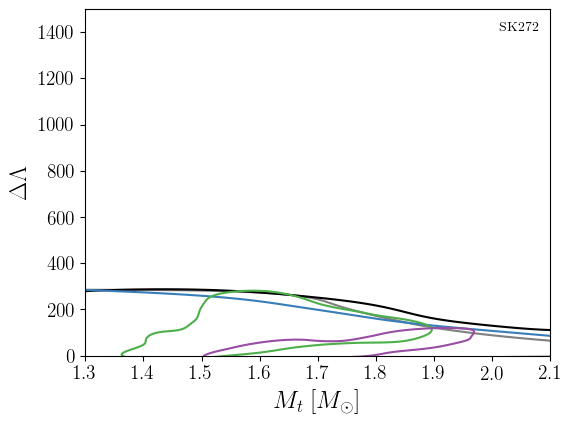

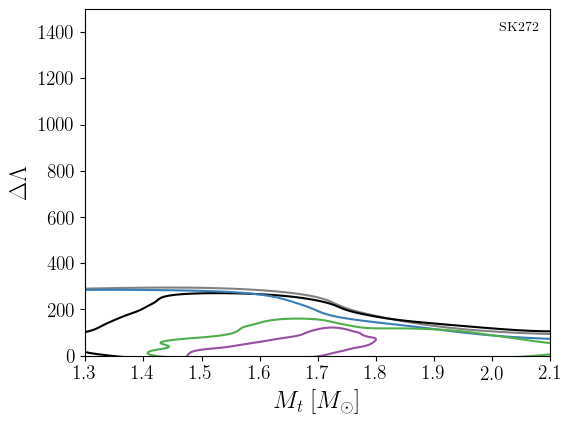

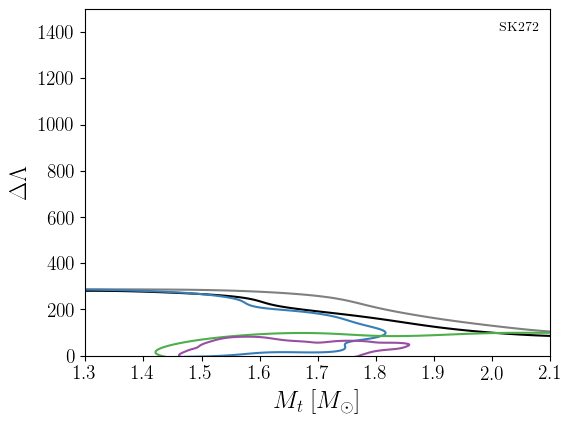

In [8]:
eos = 'SK272'
short_scenarios = ['O5','O5','3G','3G','3G']
scenarios = ['O5','O5y2','3Gd1','3Gw1','3Gm1']
scenario_dict = {'O5': r'A+ (1\,y)', 'O5y2': r'A+ (2\,y)', '3Gd1': r'XG (1\,d)', '3Gw1': r'XG (1\,w)', '3Gm1': r'XG (1\,m)'}
colors = ['grey','k',sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[3]]
pops = ['v0','v1','v2','v3','v4', 'v5','v6','v7','v8','v9']

for pop in pops:
    
    plt.figure(figsize=(6,4.5))

    for i,scenario in enumerate(scenarios):  
    
        postpath = DATDIR+'unif_BNS_{1}{2}/{0}_unif_BNS_{1}_recovery-{3}.csv'.format(short_scenarios[i],eos,pop,scenario)

        post_dat = np.genfromtxt(postpath,names=True,delimiter=',',dtype=None,encoding=None)
        Mtwins = post_dat['Mt']
        DeltaLs = post_dat['DeltaL']

        refs_DeltaLs = np.where(DeltaLs < 10.)
        DeltaLs_ref = -np.abs(DeltaLs[refs_DeltaLs])

        refs_Mtwins = np.where(Mtwins < 1.1)
        Mtwins_ref = 1.-np.abs(Mtwins[refs_Mtwins]-1.)

        sns.kdeplot(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),levels=[0.1],color=colors[i])#,label=scenario_dict[scenario]
        #if scenario == '3Gm1': plt.scatter(list(Mtwins)+list(Mtwins[refs_DeltaLs])+list(Mtwins_ref),list(DeltaLs)+list(DeltaLs_ref)+list(DeltaLs[refs_Mtwins]),c='k',alpha=0.1,marker='.')
        
    injpath = DATDIR+'unif_BNS_{0}{1}/{0}_twinstarparameters.csv'.format(eos,pop)
    inj_dat = np.genfromtxt(injpath,names=True,delimiter=',',dtype=None,encoding=None)
    plt.scatter(inj_dat['Mt'],inj_dat['DeltaL'],marker='+',c=sns.color_palette()[0],zorder=10,label='SK272',alpha=0.)
    #plt.errorbar(inj_dat['Mt'],inj_dat['DeltaL'],yerr=0.,xerr=0.068,marker='+',c=sns.color_palette()[0],zorder=10,label='injection')
    
    plt.xlim(1.,2.)
    plt.ylim(0.,1400.)
    plt.ylabel(r'$\Delta\Lambda$',size=18)
    plt.xlabel(r'$M_t\;[M_\odot]$',size=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False,handlelength=0.)
    plt.savefig(PLTDIR+eos+'_MtDeltaL'+pop+'.png',bbox_inches="tight")